<a href="https://colab.research.google.com/github/mcomegalletas/AIClassProjects/blob/main/Neural%20Network%20-%20Letter%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importacion de librerias:


In [ ]:
reso= 28

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Lectura de la base de datos desde imagenes

In [ ]:
def plot_num(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [ ]:


# Directorio de entrenamiento y prueba
train_dir = 'Dataset/Training'
test_dir =  'Dataset/Testing'

# Tamaño de las imágenes
img_size = (reso, reso)

# Función para cargar las imágenes y sus etiquetas
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                label = ord(subfolder.lower()) - 97 # Convertir la letra en un número entre 0 y 25
                img = Image.open(img_path).convert('L') # Convertir a escala de grises
                img = img.resize(img_size) # Redimensionar la imagen
                img_array = np.array(img)
                #img_array = np.expand_dims(img_array, axis=-1) # Agregar una dimensión para el canal
                images.append(img_array)
                labels.append(label)
    return images,labels


In [ ]:

# Carga de imágenes de entrenamiento y prueba
x_train_images, y_train_labels = load_images_from_folder(train_dir)
x_test_images, y_test_labels = load_images_from_folder(test_dir)
sha=np.array(x_train_images).shape[0]
sha2= np.array(x_test_images).shape[0]

# Convertir las imágenes en vectores
x_train = np.array(x_train_images).reshape(sha, -1).astype(np.float32)/255.0
#x_val = np.array(x_train_images)[401:].reshape(100, -1).astype(np.float32)/255.0
x_test = np.array(x_test_images).copy().reshape(sha2, -1).astype(np.float32)/255.0

y_train = np.array(y_train_labels).reshape(sha, 1)
y_test = np.array(y_test_labels).reshape(sha2, 1)
#y_val = np.array(y_train_labels)[401:].reshape(100, 1)



# Mostrar la forma de los conjuntos de datos
print("Shape de x_train:", np.shape(x_train))
print("Shape de y_train:", np.shape(y_train))
#print("Shape de x_val:", np.shape(x_val))
#print("Shape de y_val:", np.shape(y_val))
print("Shape de x_test:", np.shape(x_test))
print("Shape de y_test:", np.shape(y_test))


#for i in range(501):
   # plot_num(x_train_images[i])



d:\Anaconda\envs\AIEnv\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Shape de x_train: (767, 784)
Shape de y_train: (767, 1)
Shape de x_test: (417, 784)
Shape de y_test: (417, 1)


In [ ]:

def set_minibatches(mb_size, x, y, shuffle = True):
    '''
    x #muestras, 784
    y #muestras, 1'''

    assert x.shape[0] == y.shape[0], 'erroro en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs= np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data,mb_size))

In [1]:
def init_parametros(input_size, neuronas):
    '''
    esta funcion inicializa el valor inicial de los datos
    input_size-> elementos de entrada
    neuronas-> list[200, 10] -> neuronas capa actual, neuronas capa siguiente con la cantidad de neuronas en cada capa
    esta funcion regresa un diccionario con los valores de W1 b1 W2 b2
    '''
    W1 = np.random.randn(neuronas[0], input_size) * 0.001
    b1 = np.zeros((neuronas[0], 1))

    W2 = np.random.randn(neuronas[1], neuronas[0]) * 0.001 #filas:numero de neuronas de la capa columnas: numero de neuronas de la capa siguiente
    b2 = np.zeros((neuronas[1],1))

    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def relu(z):
    '''
    la funcion ReLu, corta los valores negativos, es decir, los hace cero
    y regresa los valore maximos
    '''
    return np.maximum(0,z)

def scores(x, parametros, funActivacion):
    '''Esta funcion regresa los scores de las operaciones matematicas
    de la neurona, es decir el forward prop
    X-> debe ingresar de manera transpuesta con la forma (pixeles, examples) '''
    Z1 = parametros['W1'] @ x + parametros['b1']
    a1 = funActivacion(Z1)
    Z2 = parametros['W2'] @ a1 + parametros['b2']

    return Z2, Z1, a1


def softmax(Z):
    exp_scores = np.exp(Z)
    sum_exp= np.sum(exp_scores, axis=0) # esto es para hacer la suma de unicamente entre las columnas, y no con las filas
    probs= exp_scores/sum_exp
    return probs

def loss_entropy(scores, y, batch_size= 64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    return probs, cost

def backProp(probs, x, y, Z1, a1, parametros, batch_size=64):
    grad = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y_hat - y
    dZ2 = probs.copy()

    dW2 = dZ2 @ a1.T / batch_size
    db2 = np.sum(dZ2, axis = 1, keepdims = True)/ batch_size
    da1 = parametros['W2'].T @ dZ2

    dZ1 = da1.copy()
    dZ1[Z1 <= 0] = 0

    dW1 = dZ1 @ x
    db1 = np.sum(dZ1, axis=1, keepdims= True)

    assert parametros['W1'].shape == dW1.shape, 'error en la forma de W1'
    assert parametros['W2'].shape == dW2.shape, 'error en la forma de W2'
    assert parametros['b1'].shape == db1.shape, 'error en la forma de b1'
    assert parametros['b2'].shape == db2.shape, 'error en la forma de b2'
    grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    return grads


def get_accuracy(x_data, y_data, parametros, mb_size = 64):
    correct =0
    total = 0
    for i, (x, y) in enumerate(set_minibatches(mb_size, x_data, y_data)):
        sco, Z1, a1 = scores(x.T, parametros, relu)
        y_hat, cost = loss_entropy(sco, y,batch_size= len(x))

        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]

    return correct/total

In [ ]:
def train(epocas, parametros, x_t, y_t, mb_size=64, alpha=1e-3):
    print("inicio del entrenamineto")
    for epoch in range(epocas):
        for i,(x, y) in enumerate(set_minibatches(mb_size, x_t, y_t)):
            sco, Z1, a1 = scores(x.T, parametros, relu)
            y_hat, cost = loss_entropy(sco, y,batch_size= len(x))
            grads = backProp(y_hat, x, y, Z1, a1, parametros, batch_size=len(x))
            # actualizar parametros
            parametros['W1'] = parametros['W1'] - alpha* grads['W1']
            parametros['W2'] = parametros['W2'] - alpha* grads['W2']
            parametros['b1'] = parametros['b1'] - alpha* grads['b1']
            parametros['b2'] = parametros['b2'] - alpha* grads['b2']
        print(f'Epoca actual: {epoch}')
        print(f'el loss actual es: {cost}')
        print(f'la exactitud actual es: {get_accuracy(x_train, y_train, parametros, mb_size)}')
    return parametros

In [ ]:
mb_size = 28
alpha = 1e-3
epochs = 500
input_size = reso*reso
neuronas = [50, 26]
parametros= init_parametros(input_size, neuronas)
finales=train(epochs, parametros, x_train, y_train, mb_size, alpha)

inicio del entrenamineto
Epoca actual: 0
el loss actual es: 3.258091701912473
la exactitud actual es: 0.023980815347721823
Epoca actual: 1
el loss actual es: 3.2580838707019812
la exactitud actual es: 0.023980815347721823
Epoca actual: 2
el loss actual es: 3.2581376109243165
la exactitud actual es: 0.023980815347721823
Epoca actual: 3
el loss actual es: 3.257847302352599
la exactitud actual es: 0.023980815347721823
Epoca actual: 4
el loss actual es: 3.2579339111343604
la exactitud actual es: 0.023980815347721823
Epoca actual: 5
el loss actual es: 3.2575672636473003
la exactitud actual es: 0.023980815347721823
Epoca actual: 6
el loss actual es: 3.257615226080956
la exactitud actual es: 0.023980815347721823
Epoca actual: 7
el loss actual es: 3.2577708812514676
la exactitud actual es: 0.023980815347721823
Epoca actual: 8
el loss actual es: 3.257522483650275
la exactitud actual es: 0.023980815347721823
Epoca actual: 9
el loss actual es: 3.2576056211258315
la exactitud actual es: 0.02398081

In [ ]:
# ejecucion de los datos de prueba
get_accuracy(x_test, y_test, parametros=parametros, mb_size=mb_size)

0.8752997601918465

In [ ]:
def getLetra(numero):
    return chr(numero + 65)

In [ ]:
#predicciones
def predecir(x, parametros):
    scores2,_,_= scores(x,parametros,relu)
    return np.argmax(scores2)
    #return scores2

x_test[0].reshape(-1,1).shape

(784, 1)

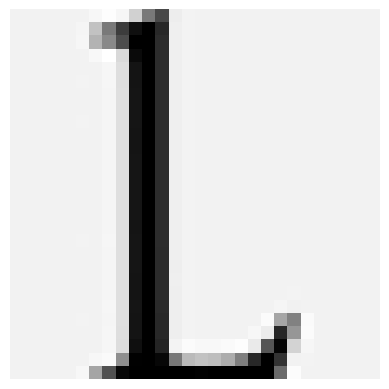

la imagen muestreada representa un: L
el valor predicho es: L


In [ ]:
#prueba con imagenes del dataset
idx = np.random.randint(len(y_test))
plot_num(x_test_images[idx])
print(f'la imagen muestreada representa un: {getLetra(y_test_labels[idx])}')
predi = predecir(x_test[idx].reshape(-1,1), finales)
print(f'el valor predicho es: {getLetra(predi)}')

(28, 28)


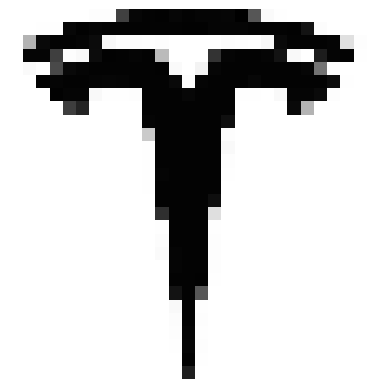

(784, 1)
el valor predicho es: T


In [ ]:
fname = "tesla.jpg"
x= img_to_array(load_img(fname, color_mode = "grayscale", target_size=(reso,reso)))
x= np.average(x, axis = 2)
x=x/255
print(x.shape)
nose = np.ones((reso,reso))

final=x
plot_num(final)

imagen= final.reshape(-1, 1)
print(imagen.shape)
predi=predecir(imagen, finales)
predi = getLetra(predi)
print(f'el valor predicho es: {predi}')